# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.02.15

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208

This data is DNA of uncleared MERFISH RNA:
    \\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd
from tqdm import tqdm

58596


In [2]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'save_folder':r'\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'experiment_type': 'DNA',
             'num_threads': 25,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':10,
                     'max_num_seeds': 2000,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False
                 }, 
             }

## 1.1 define required floders

In [3]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation', 'Tests')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots', 'Tests')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


163 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests
Use cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots\Tests
Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests


## 1.2 get dict for cell uid

In [4]:
%%time
_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')

fovcell_2_uid = {}
with h5py.File(_total_seg_save_file, 'r') as _f:
    for _fov_id in _f.keys():
        _fov_group = _f[_fov_id]
        _uid_group = _fov_group['cell_2_uid']
        for _cell_id in _uid_group.keys():
            fovcell_2_uid[(_fov_id, _cell_id)] = _uid_group[_cell_id][:][0].decode()
print(len(fovcell_2_uid))

22712
Wall time: 6.5 s


## 1.3 get cell_uid to cell-class

In [5]:
%%time
import scanpy as sc

# load cell type info
merfish_cluster_file = r'\\mendel\Mendel_SSD1\Pu_Temp\20220208MO4_nonclear\filtered_cluster_data_labeled.h5ad'

merfish_df = sc.read_h5ad(merfish_cluster_file)

uid_2_class = {_uid:_class for _uid, _class in zip(merfish_df.obs.index, merfish_df.obs['subclass_manual_label'])}

Wall time: 7.92 s


# 2. export spot_groups

In [27]:
%%time
from ImageAnalysis3.classes import decode
# loop through fovs
load_key = 'spot_groups'
# save into file
export_decode_folder = r'H:\20220215-Export'

overwrite_export = False

SpotGroupDfs = []
for _fov_id in save_fov_ids:
    _export_filename = os.path.join(export_decode_folder, f"DecodeGroup_Fov-{_fov_id}.hdf5")
    print(_export_filename)
    if os.path.exists(_export_filename) and not overwrite_export:
        continue
    _cell_ids = [_g[1] for _g in fovcell_2_uid.keys() if str(_g[0])==str(_fov_id)]
    for _cell_id in tqdm(_cell_ids):
        _decoder_filename = os.path.join(decoder_folder, 
                                         f"Fov-{_fov_id}_Cell-{_cell_id}_Decoder.hdf5")
        if os.path.isfile(_decoder_filename):
            #print(_fov_id, _cell_id)
            _df = pd.read_hdf(_decoder_filename, load_key)
            _uid = fovcell_2_uid[(str(_fov_id), _cell_id)]
            _df['uid'] = _uid
            # merfish class
            _class = merfish_df.obs.loc[merfish_df.obs.index==_uid,'subclass_manual_label'].values
            if len(_class) == 0:
                _df['manual_class'] = None
            else:
                _df['manual_class'] = _class[0]
                
            SpotGroupDfs.append(_df)
            # save this df
            _df.to_hdf(_export_filename, f"Cell-{_cell_id}", complevel=1, complib='blosc:zstd')
            # save EM picked spots
            _dict = ia.classes.decode.load_hdf5_dict(_decoder_filename, 'chr_2_zxys_list')
            if isinstance(_dict, dict):
                ia.classes.decode.save_hdf5_dict(_export_filename, f"Cell-{_cell_id}_EM", _dict)


  1%|█▏                                                                                                                                                                  | 1/141 [00:00<00:14,  9.42it/s]

H:\20220215-Export\DecodeGroup_Fov-0.hdf5
H:\20220215-Export\DecodeGroup_Fov-1.hdf5
H:\20220215-Export\DecodeGroup_Fov-2.hdf5
H:\20220215-Export\DecodeGroup_Fov-3.hdf5
H:\20220215-Export\DecodeGroup_Fov-4.hdf5
H:\20220215-Export\DecodeGroup_Fov-5.hdf5
H:\20220215-Export\DecodeGroup_Fov-6.hdf5
H:\20220215-Export\DecodeGroup_Fov-7.hdf5
H:\20220215-Export\DecodeGroup_Fov-8.hdf5
H:\20220215-Export\DecodeGroup_Fov-9.hdf5
H:\20220215-Export\DecodeGroup_Fov-10.hdf5
H:\20220215-Export\DecodeGroup_Fov-11.hdf5
H:\20220215-Export\DecodeGroup_Fov-12.hdf5
H:\20220215-Export\DecodeGroup_Fov-13.hdf5
H:\20220215-Export\DecodeGroup_Fov-14.hdf5
H:\20220215-Export\DecodeGroup_Fov-15.hdf5
H:\20220215-Export\DecodeGroup_Fov-16.hdf5
H:\20220215-Export\DecodeGroup_Fov-17.hdf5
H:\20220215-Export\DecodeGroup_Fov-18.hdf5
H:\20220215-Export\DecodeGroup_Fov-19.hdf5
H:\20220215-Export\DecodeGroup_Fov-20.hdf5
H:\20220215-Export\DecodeGroup_Fov-21.hdf5
H:\20220215-Export\DecodeGroup_Fov-22.hdf5
H:\20220215-Export\De

  1%|█▋                                                                                                                                                                  | 2/189 [00:00<00:16, 11.04it/s]

H:\20220215-Export\DecodeGroup_Fov-29.hdf5


  0%|                                                                                                                                                                            | 0/216 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-30.hdf5


 52%|████████████████████████████████████████████████████████████████████████████████████                                                                              | 112/216 [00:07<00:06, 15.04it/s]E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-200'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|█▌                                                                                                                                                                  | 2/212 [00:00<00:20, 10.46it/s]

H:\20220215-Export\DecodeGroup_Fov-31.hdf5


 59%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 125/212 [00:09<00:05, 17.02it/s]E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-211'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▉                                                                                                                                                                   | 1/180 [00:00<00:18,  9.89it/s]

H:\20220215-Export\DecodeGroup_Fov-32.hdf5


  1%|█▋                                                                                                                                                                  | 2/188 [00:00<00:17, 10.86it/s]

H:\20220215-Export\DecodeGroup_Fov-33.hdf5


  0%|                                                                                                                                                                            | 0/109 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-34.hdf5


  1%|█▎                                                                                                                                                                  | 1/125 [00:00<00:12,  9.99it/s]

H:\20220215-Export\DecodeGroup_Fov-35.hdf5


  2%|██▉                                                                                                                                                                 | 2/112 [00:00<00:09, 11.62it/s]

H:\20220215-Export\DecodeGroup_Fov-36.hdf5


  0%|                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-37.hdf5


  2%|███                                                                                                                                                                 | 2/106 [00:00<00:07, 14.37it/s]

H:\20220215-Export\DecodeGroup_Fov-38.hdf5


  0%|                                                                                                                                                                            | 0/182 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-39.hdf5


  0%|                                                                                                                                                                            | 0/166 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-40.hdf5


  0%|                                                                                                                                                                            | 0/116 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-41.hdf5


  0%|                                                                                                                                                                            | 0/148 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-42.hdf5


  1%|█▌                                                                                                                                                                  | 1/107 [00:00<00:11,  9.25it/s]

H:\20220215-Export\DecodeGroup_Fov-43.hdf5


  1%|█▎                                                                                                                                                                  | 1/121 [00:00<00:13,  8.69it/s]

H:\20220215-Export\DecodeGroup_Fov-44.hdf5


  1%|█                                                                                                                                                                   | 1/156 [00:00<00:19,  7.99it/s]

H:\20220215-Export\DecodeGroup_Fov-45.hdf5


  0%|                                                                                                                                                                            | 0/113 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-46.hdf5


  1%|█▏                                                                                                                                                                  | 1/133 [00:00<00:13,  9.89it/s]

H:\20220215-Export\DecodeGroup_Fov-47.hdf5


  0%|                                                                                                                                                                            | 0/153 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-48.hdf5


  1%|█▉                                                                                                                                                                  | 2/170 [00:00<00:15, 11.11it/s]

H:\20220215-Export\DecodeGroup_Fov-49.hdf5


  1%|█▊                                                                                                                                                                  | 2/182 [00:00<00:15, 11.69it/s]

H:\20220215-Export\DecodeGroup_Fov-50.hdf5


  0%|                                                                                                                                                                            | 0/157 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-51.hdf5


  1%|█▏                                                                                                                                                                  | 1/133 [00:00<00:14,  9.00it/s]

H:\20220215-Export\DecodeGroup_Fov-52.hdf5


  0%|                                                                                                                                                                            | 0/133 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-53.hdf5


  2%|██▌                                                                                                                                                                 | 2/129 [00:00<00:06, 18.17it/s]

H:\20220215-Export\DecodeGroup_Fov-54.hdf5


  1%|█                                                                                                                                                                   | 1/147 [00:00<00:16,  8.76it/s]

H:\20220215-Export\DecodeGroup_Fov-55.hdf5


  1%|█                                                                                                                                                                   | 1/155 [00:00<00:17,  8.69it/s]

H:\20220215-Export\DecodeGroup_Fov-56.hdf5


  1%|██▏                                                                                                                                                                 | 2/148 [00:00<00:12, 11.76it/s]

H:\20220215-Export\DecodeGroup_Fov-57.hdf5


  1%|█                                                                                                                                                                   | 1/155 [00:00<00:17,  8.84it/s]

H:\20220215-Export\DecodeGroup_Fov-58.hdf5


  1%|█▏                                                                                                                                                                  | 1/135 [00:00<00:15,  8.61it/s]

H:\20220215-Export\DecodeGroup_Fov-59.hdf5


  1%|█▏                                                                                                                                                                  | 1/137 [00:00<00:14,  9.43it/s]

H:\20220215-Export\DecodeGroup_Fov-60.hdf5


  1%|█▍                                                                                                                                                                  | 1/114 [00:00<00:12,  8.77it/s]

H:\20220215-Export\DecodeGroup_Fov-61.hdf5


  1%|█▍                                                                                                                                                                  | 1/117 [00:00<00:13,  8.61it/s]

H:\20220215-Export\DecodeGroup_Fov-62.hdf5


  0%|                                                                                                                                                                            | 0/128 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-63.hdf5


  2%|███                                                                                                                                                                 | 2/105 [00:00<00:09, 11.42it/s]

H:\20220215-Export\DecodeGroup_Fov-64.hdf5


  2%|██▉                                                                                                                                                                 | 2/110 [00:00<00:09, 11.42it/s]

H:\20220215-Export\DecodeGroup_Fov-65.hdf5


  1%|██▏                                                                                                                                                                 | 2/146 [00:00<00:12, 11.62it/s]

H:\20220215-Export\DecodeGroup_Fov-66.hdf5


  1%|██                                                                                                                                                                  | 2/155 [00:00<00:13, 11.69it/s]

H:\20220215-Export\DecodeGroup_Fov-67.hdf5


  0%|                                                                                                                                                                            | 0/156 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-68.hdf5


  2%|██▉                                                                                                                                                                 | 3/167 [00:00<00:08, 18.50it/s]

H:\20220215-Export\DecodeGroup_Fov-69.hdf5


  1%|█▉                                                                                                                                                                  | 2/167 [00:00<00:15, 10.80it/s]

H:\20220215-Export\DecodeGroup_Fov-70.hdf5


  1%|█▉                                                                                                                                                                  | 2/171 [00:00<00:15, 11.16it/s]

H:\20220215-Export\DecodeGroup_Fov-71.hdf5


  0%|                                                                                                                                                                            | 0/144 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-72.hdf5


  0%|                                                                                                                                                                            | 0/148 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-73.hdf5


  1%|█▋                                                                                                                                                                   | 1/97 [00:00<00:09,  9.70it/s]

H:\20220215-Export\DecodeGroup_Fov-74.hdf5


  2%|███▊                                                                                                                                                                | 3/127 [00:00<00:06, 18.17it/s]

H:\20220215-Export\DecodeGroup_Fov-75.hdf5


  2%|██▋                                                                                                                                                                 | 2/124 [00:00<00:10, 11.83it/s]

H:\20220215-Export\DecodeGroup_Fov-76.hdf5


  0%|                                                                                                                                                                            | 0/123 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-77.hdf5


  1%|█                                                                                                                                                                   | 1/146 [00:00<00:19,  7.29it/s]

H:\20220215-Export\DecodeGroup_Fov-78.hdf5


  1%|█▎                                                                                                                                                                  | 1/125 [00:00<00:13,  9.08it/s]

H:\20220215-Export\DecodeGroup_Fov-79.hdf5


  1%|█▏                                                                                                                                                                  | 1/138 [00:00<00:16,  8.47it/s]

H:\20220215-Export\DecodeGroup_Fov-80.hdf5


  0%|                                                                                                                                                                             | 0/14 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-81.hdf5


  0%|                                                                                                                                                                             | 0/27 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-82.hdf5


  0%|                                                                                                                                                                             | 0/24 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-83.hdf5


  0%|                                                                                                                                                                             | 0/44 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-84.hdf5


  4%|█████▉                                                                                                                                                               | 1/28 [00:00<00:02,  9.70it/s]

H:\20220215-Export\DecodeGroup_Fov-85.hdf5


 11%|█████████████████▎                                                                                                                                                   | 2/19 [00:00<00:01, 16.51it/s]

H:\20220215-Export\DecodeGroup_Fov-86.hdf5


  1%|█▎                                                                                                                                                                  | 1/126 [00:00<00:14,  8.54it/s]

H:\20220215-Export\DecodeGroup_Fov-87.hdf5
H:\20220215-Export\DecodeGroup_Fov-88.hdf5


  1%|█▍                                                                                                                                                                  | 1/114 [00:00<00:16,  6.84it/s]

H:\20220215-Export\DecodeGroup_Fov-89.hdf5


  1%|█▋                                                                                                                                                                  | 1/100 [00:00<00:10,  9.08it/s]

H:\20220215-Export\DecodeGroup_Fov-90.hdf5


  1%|█▋                                                                                                                                                                   | 1/97 [00:00<00:10,  9.34it/s]

H:\20220215-Export\DecodeGroup_Fov-91.hdf5


  1%|█▌                                                                                                                                                                  | 1/103 [00:00<00:11,  8.61it/s]

H:\20220215-Export\DecodeGroup_Fov-92.hdf5


  1%|█▊                                                                                                                                                                  | 2/179 [00:00<00:16, 10.69it/s]

H:\20220215-Export\DecodeGroup_Fov-93.hdf5


  1%|█▋                                                                                                                                                                  | 2/192 [00:00<00:16, 11.76it/s]

H:\20220215-Export\DecodeGroup_Fov-94.hdf5


  0%|                                                                                                                                                                            | 0/194 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-95.hdf5


  1%|▊                                                                                                                                                                   | 1/196 [00:00<00:19,  9.80it/s]

H:\20220215-Export\DecodeGroup_Fov-96.hdf5


 54%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 106/196 [00:07<00:03, 25.12it/s]E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-195'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|                                                                                                                                                                            | 0/184 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-97.hdf5


  0%|                                                                                                                                                                            | 0/180 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-98.hdf5


  0%|                                                                                                                                                                            | 0/153 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-99.hdf5


  1%|██                                                                                                                                                                  | 2/164 [00:00<00:14, 11.49it/s]

H:\20220215-Export\DecodeGroup_Fov-100.hdf5


  2%|██▊                                                                                                                                                                 | 2/117 [00:00<00:10, 10.98it/s]

H:\20220215-Export\DecodeGroup_Fov-101.hdf5


  0%|                                                                                                                                                                            | 0/123 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-102.hdf5


  0%|                                                                                                                                                                            | 0/107 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-103.hdf5


  1%|██                                                                                                                                                                  | 2/161 [00:00<00:14, 10.86it/s]

H:\20220215-Export\DecodeGroup_Fov-104.hdf5


  1%|██▏                                                                                                                                                                 | 2/148 [00:00<00:12, 11.62it/s]

H:\20220215-Export\DecodeGroup_Fov-105.hdf5


  1%|█▎                                                                                                                                                                  | 1/121 [00:00<00:12,  9.61it/s]

H:\20220215-Export\DecodeGroup_Fov-106.hdf5


  0%|                                                                                                                                                                            | 0/124 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-107.hdf5


  0%|                                                                                                                                                                            | 0/169 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-108.hdf5


  0%|                                                                                                                                                                            | 0/181 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-109.hdf5


  0%|                                                                                                                                                                            | 0/178 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-110.hdf5


  0%|                                                                                                                                                                            | 0/200 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-111.hdf5


  1%|██▎                                                                                                                                                                 | 2/143 [00:00<00:12, 11.29it/s]

H:\20220215-Export\DecodeGroup_Fov-112.hdf5


  1%|██▏                                                                                                                                                                 | 2/150 [00:00<00:13, 10.57it/s]

H:\20220215-Export\DecodeGroup_Fov-113.hdf5


  1%|▊                                                                                                                                                                   | 1/191 [00:00<00:23,  7.93it/s]

H:\20220215-Export\DecodeGroup_Fov-114.hdf5


  0%|▊                                                                                                                                                                   | 1/204 [00:00<00:23,  8.54it/s]

H:\20220215-Export\DecodeGroup_Fov-115.hdf5


  1%|▉                                                                                                                                                                   | 1/178 [00:00<00:18,  9.34it/s]

H:\20220215-Export\DecodeGroup_Fov-116.hdf5


  1%|█▌                                                                                                                                                                  | 2/208 [00:00<00:20, 10.25it/s]

H:\20220215-Export\DecodeGroup_Fov-117.hdf5


 55%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 115/208 [00:09<00:04, 20.90it/s]E:\Users\puzheng\AppData\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-202'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|                                                                                                                                                                            | 0/189 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-118.hdf5


  1%|██▏                                                                                                                                                                 | 2/152 [00:00<00:14, 10.63it/s]

H:\20220215-Export\DecodeGroup_Fov-119.hdf5


  1%|█                                                                                                                                                                   | 1/151 [00:00<00:15,  9.99it/s]

H:\20220215-Export\DecodeGroup_Fov-120.hdf5


  0%|                                                                                                                                                                            | 0/123 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-121.hdf5


  0%|                                                                                                                                                                            | 0/142 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-122.hdf5


  1%|▉                                                                                                                                                                   | 1/178 [00:00<00:18,  9.34it/s]

H:\20220215-Export\DecodeGroup_Fov-123.hdf5


  0%|                                                                                                                                                                            | 0/145 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-124.hdf5


  1%|██▏                                                                                                                                                                 | 2/152 [00:00<00:13, 10.75it/s]

H:\20220215-Export\DecodeGroup_Fov-125.hdf5


  0%|                                                                                                                                                                            | 0/206 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-126.hdf5


 20%|█████████████████████████████████                                                                                                                                    | 2/10 [00:00<00:00, 11.90it/s]

H:\20220215-Export\DecodeGroup_Fov-127.hdf5


 12%|████████████████████▋                                                                                                                                                | 2/16 [00:00<00:01, 12.33it/s]

H:\20220215-Export\DecodeGroup_Fov-128.hdf5


 10%|████████████████▌                                                                                                                                                    | 2/20 [00:00<00:01, 11.55it/s]

H:\20220215-Export\DecodeGroup_Fov-129.hdf5


 25%|█████████████████████████████████████████▌                                                                                                                            | 1/4 [00:00<00:00,  8.06it/s]

H:\20220215-Export\DecodeGroup_Fov-130.hdf5


  2%|███▌                                                                                                                                                                 | 2/93 [00:00<00:08, 11.29it/s]

H:\20220215-Export\DecodeGroup_Fov-131.hdf5


  0%|                                                                                                                                                                            | 0/143 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-132.hdf5


  1%|██▏                                                                                                                                                                 | 2/151 [00:00<00:13, 11.36it/s]

H:\20220215-Export\DecodeGroup_Fov-133.hdf5


  0%|                                                                                                                                                                            | 0/130 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-134.hdf5


  0%|                                                                                                                                                                            | 0/136 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-135.hdf5


  1%|█▍                                                                                                                                                                  | 1/112 [00:00<00:13,  8.26it/s]

H:\20220215-Export\DecodeGroup_Fov-136.hdf5


  1%|█                                                                                                                                                                   | 1/159 [00:00<00:18,  8.77it/s]

H:\20220215-Export\DecodeGroup_Fov-137.hdf5


  1%|▉                                                                                                                                                                   | 1/182 [00:00<00:19,  9.25it/s]

H:\20220215-Export\DecodeGroup_Fov-138.hdf5


  0%|                                                                                                                                                                            | 0/188 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-139.hdf5


  1%|█▉                                                                                                                                                                  | 2/166 [00:00<00:15, 10.63it/s]

H:\20220215-Export\DecodeGroup_Fov-140.hdf5


  0%|                                                                                                                                                                            | 0/155 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-141.hdf5


  0%|                                                                                                                                                                            | 0/150 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-142.hdf5


  2%|██▍                                                                                                                                                                 | 2/132 [00:00<00:11, 11.55it/s]

H:\20220215-Export\DecodeGroup_Fov-143.hdf5


  0%|                                                                                                                                                                            | 0/142 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-144.hdf5


  2%|██▌                                                                                                                                                                 | 2/125 [00:00<00:11, 10.80it/s]

H:\20220215-Export\DecodeGroup_Fov-145.hdf5


  0%|                                                                                                                                                                            | 0/162 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-146.hdf5


  1%|█▍                                                                                                                                                                  | 1/117 [00:00<00:11,  9.70it/s]

H:\20220215-Export\DecodeGroup_Fov-147.hdf5


  2%|██▋                                                                                                                                                                 | 2/124 [00:00<00:11, 10.46it/s]

H:\20220215-Export\DecodeGroup_Fov-148.hdf5


  1%|█▎                                                                                                                                                                  | 1/125 [00:00<00:14,  8.47it/s]

H:\20220215-Export\DecodeGroup_Fov-149.hdf5


  1%|█▎                                                                                                                                                                  | 1/122 [00:00<00:15,  7.93it/s]

H:\20220215-Export\DecodeGroup_Fov-150.hdf5


  1%|█▏                                                                                                                                                                  | 1/132 [00:00<00:15,  8.33it/s]

H:\20220215-Export\DecodeGroup_Fov-151.hdf5


  1%|█                                                                                                                                                                   | 1/161 [00:00<00:18,  8.54it/s]

H:\20220215-Export\DecodeGroup_Fov-152.hdf5


  1%|█                                                                                                                                                                   | 1/160 [00:00<00:19,  8.19it/s]

H:\20220215-Export\DecodeGroup_Fov-153.hdf5


  1%|█▏                                                                                                                                                                  | 1/134 [00:00<00:15,  8.33it/s]

H:\20220215-Export\DecodeGroup_Fov-154.hdf5


  1%|▉                                                                                                                                                                   | 1/169 [00:00<00:21,  7.75it/s]

H:\20220215-Export\DecodeGroup_Fov-155.hdf5


  1%|▉                                                                                                                                                                   | 1/176 [00:00<00:17,  9.99it/s]

H:\20220215-Export\DecodeGroup_Fov-156.hdf5


  1%|▉                                                                                                                                                                   | 1/181 [00:00<00:20,  8.61it/s]

H:\20220215-Export\DecodeGroup_Fov-157.hdf5


  1%|█                                                                                                                                                                   | 1/147 [00:00<00:17,  8.33it/s]

H:\20220215-Export\DecodeGroup_Fov-158.hdf5


  1%|█▎                                                                                                                                                                  | 1/128 [00:00<00:14,  8.62it/s]

H:\20220215-Export\DecodeGroup_Fov-159.hdf5


  1%|█                                                                                                                                                                   | 1/154 [00:00<00:17,  8.84it/s]

H:\20220215-Export\DecodeGroup_Fov-160.hdf5


  1%|█▎                                                                                                                                                                  | 1/128 [00:00<00:15,  8.40it/s]

H:\20220215-Export\DecodeGroup_Fov-161.hdf5


  0%|                                                                                                                                                                            | 0/170 [00:00<?, ?it/s]

H:\20220215-Export\DecodeGroup_Fov-162.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:22<00:00,  7.72it/s]

Wall time: 36min 1s


In [19]:
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

- Update Cell-1_EM into H:\20220215-Export\DecodeGroup_Fov-0.hdf5
-- overwrite 1 in Cell-1_EM
-- saving 1 in Cell-1_EM
-- overwrite 10 in Cell-1_EM
-- saving 10 in Cell-1_EM
-- overwrite 11 in Cell-1_EM
-- saving 11 in Cell-1_EM
-- overwrite 12 in Cell-1_EM
-- saving 12 in Cell-1_EM
-- overwrite 13 in Cell-1_EM
-- saving 13 in Cell-1_EM
-- overwrite 14 in Cell-1_EM
-- saving 14 in Cell-1_EM
-- overwrite 15 in Cell-1_EM
-- saving 15 in Cell-1_EM
-- overwrite 16 in Cell-1_EM
-- saving 16 in Cell-1_EM
-- overwrite 17 in Cell-1_EM
-- saving 17 in Cell-1_EM
-- overwrite 18 in Cell-1_EM
-- saving 18 in Cell-1_EM
-- overwrite 19 in Cell-1_EM
-- saving 19 in Cell-1_EM
-- overwrite 2 in Cell-1_EM
-- saving 2 in Cell-1_EM
-- overwrite 3 in Cell-1_EM
-- saving 3 in Cell-1_EM
-- overwrite 4 in Cell-1_EM
-- saving 4 in Cell-1_EM
-- overwrite 5 in Cell-1_EM
-- saving 5 in Cell-1_EM
-- overwrite 6 in Cell-1_EM
-- saving 6 in Cell-1_EM
-- overwrite 7 in Cell-1_EM
-- saving 7 in Cell-1_EM
-- overwrite 

In [15]:
test_dict = ia.classes.decode.load_hdf5_dict(_export_filename, f"Cell-{_cell_id}_EM")

In [14]:
save_hdf5_dict(_export_filename, f"Cell-{_cell_id}_EM", _dict, _verbose=True)

- Update Cell-1_EM into H:\20220215-Export\DecodeGroup_Fov-0.hdf5
-- saving 1 in Cell-1_EM
-- saving 10 in Cell-1_EM
-- saving 11 in Cell-1_EM
-- saving 12 in Cell-1_EM
-- saving 13 in Cell-1_EM
-- saving 14 in Cell-1_EM
-- saving 15 in Cell-1_EM
-- saving 16 in Cell-1_EM
-- saving 17 in Cell-1_EM
-- saving 18 in Cell-1_EM
-- saving 19 in Cell-1_EM
-- saving 2 in Cell-1_EM
-- saving 3 in Cell-1_EM
-- saving 4 in Cell-1_EM
-- saving 5 in Cell-1_EM
-- saving 6 in Cell-1_EM
-- saving 7 in Cell-1_EM
-- saving 8 in Cell-1_EM
-- saving 9 in Cell-1_EM
-- saving X in Cell-1_EM


In [40]:
'\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests\Fov-155_Cell-100_Decoder.hdf5'

,fov_id,cell_id,uid,homolog,height_0,z_0,x_0,y_0,background_0,sigma_z_0,...,cand_spot_ind_2,pixel_z,pixel_x,pixel_y,region_id,start,end,chr,chr_order,manual_class
0,155,10,84117227764919051091421468008484379541,None,14087.587891,20.728237,150.847763,898.539978,7165.588867,1.405249,...,2248.0,250,108,108,424,58740000,58760000,7,14,None
1,155,10,84117227764919051091421468008484379541,None,12164.538086,31.101160,148.940079,913.794250,8104.825684,2.300524,...,5004.0,250,108,108,222,13740000,13760000,4,4,None
2,155,10,84117227764919051091421468008484379541,None,24108.703125,13.068707,165.707489,898.841248,9648.040039,1.396377,...,3493.0,250,108,108,774,33740000,33760000,14,8,None
3,155,10,84117227764919051091421468008484379541,None,14932.439453,14.291443,155.372650,923.636169,15775.420898,1.587620,...,1034.0,250,108,108,601,98740000,98760000,10,38,None
4,155,10,84117227764919051091421468008484379541,None,14436.699219,10.253874,179.842529,877.072876,8155.116211,1.367506,...,7929.0,250,108,108,493,83740000,83760000,8,31,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770,155,10,84117227764919051091421468008484379541,None,1564.505737,28.235369,184.814194,906.510986,17129.396484,3.232861,...,NaN,250,108,108,728,41240000,41260000,13,14,None
2771,155,10,84117227764919051091421468008484379541,None,1353.636597,13.980452,161.147766,939.599487,5755.016602,2.703635,...,NaN,250,108,108,710,116240000,116260000,12,41,None
2772,155,10,84117227764919051091421468008484379541,None,3868.593262,37.041904,196.560822,923.428955,7914.474609,2.849716,...,NaN,250,108,108,714,6240000,6260000,13,1,None
2773,155,10,84117227764919051091421468008484379541,None,1338.130615,13.966309,187.581253,931.588501,16499.000000,4.000000,...,NaN,250,108,108,718,16240000,16260000,13,5,None


In [33]:
# test loading
_export_filename = os.path.join(export_decode_folder, f"DecodeGroup_Fov-{save_fov_ids[0]}.hdf5")
pd.read_hdf(_export_filename, 'Cell-1')

# 3. load chr_2_zxys_list

## 3.1 load codebook

In [6]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910,chr,chr_order
0,1:3740000-3760000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:6240000-6260000,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1:8740000-8760000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,1:11240000-11260000,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,1:13740000-13760000,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,X:161240000-161260000,1057,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,X,52
984,X:163740000-163760000,1058,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,X,53
985,X:166240000-166260000,1059,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,X,54
986,X:168740000-168760000,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,55


## 3.2 load chr_2_zxys_list

In [14]:
#decoder_folder = os.path.join(save_folder, 'Decoder')
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in os.listdir(decoder_folder) 
                     if '_Decoder.hdf5' in _fl]
print(decoder_folder, len(decoder_filenames))

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests 18720


In [16]:
import re
import multiprocessing as mp
from ImageAnalysis3.classes.decode import load_hdf5_dict
from ImageAnalysis3.classes.decode import DNA_Merfish_Decoder

In [17]:
%%time
overwrite_coodinates=False

coord_savefile = os.path.join(decoder_folder, f'all_coordinates_Fov-{min(save_fov_ids)}-{max(save_fov_ids)}.npy')
uid_savefile = os.path.join(decoder_folder, f'all_uids_Fov-{min(save_fov_ids)}-{max(save_fov_ids)}.npy')

if os.path.exists(coord_savefile) and os.path.exists(uid_savefile) and not overwrite_coodinates:
    print("Directly load all all_zxys_list")
    all_zxys_list = np.load(coord_savefile)
    uid_list = np.load(uid_savefile)
else:
    print("Batch load all_zxys_list")
    # Batch loading
    load_args = [(_fl, 'chr_2_zxys_list') for _fl in decoder_filenames]
    print(len(load_args))
    with mp.Pool(44) as load_pool:
        all_chr_2_zxys_list = load_pool.starmap(load_hdf5_dict, 
                                                load_args, 
                                                chunksize=1)
        load_pool.close()
        load_pool.join()
        load_pool.terminate()
    # Batch summarize
    kept_decoder_filenames = [_fl for _fl,_item in zip(decoder_filenames, all_chr_2_zxys_list) if _item is not None]
    all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
    print(len(kept_decoder_filenames), len(all_chr_2_zxys_list))

    summary_args = [(_item, codebook_df) for _item in all_chr_2_zxys_list ]
    print(len(summary_args))
    with mp.Pool(44) as summary_pool: 
        all_zxys_list = summary_pool.starmap(DNA_Merfish_Decoder.summarize_zxys_by_regions, 
                                             summary_args, chunksize=1)
        summary_pool.close()
        summary_pool.join()
        summary_pool.terminate()
    # UIDs    
    uid_list = [fovcell_2_uid[
        re.findall(r'Fov-([0-9]+)_Cell-([0-9]+)_Decoder.hdf5', os.path.basename(_fl))[0]
               ] for _fl in kept_decoder_filenames]
    # SAVE
    print(f"saving coordinates into file: {coord_savefile}.")
    np.save(coord_savefile.split('.npy')[0], all_zxys_list)
    # save UID
    np.save(uid_savefile.split('.npy')[0], uid_list)

Directly load all all_zxys_list
Wall time: 863 ms


# 4. Summarize

In [18]:
save_figure = True

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Use decode_figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests\Figures


<IPython.core.display.Javascript object>


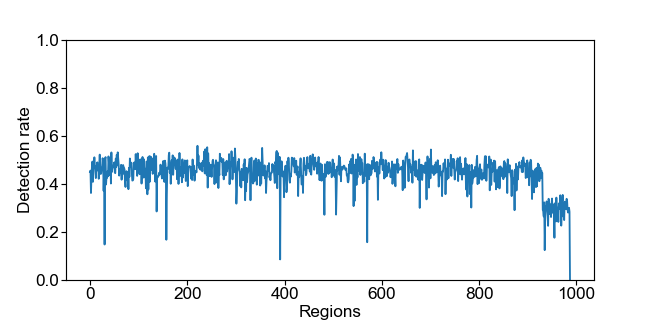

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests\Figures\loss_rates.png


In [19]:
all_zxys = np.concatenate(all_zxys_list)
loss_rates = np.mean(np.isnan(all_zxys).any(2), axis=0)

fig, ax = plt.subplots(figsize=(4,2),dpi=150)
_l = ax.plot(1-loss_rates, linewidth=0.8)
ax.set_ylim([0,1])
ax.set_xlabel('Regions', labelpad=1, fontsize=7.5)
ax.set_ylabel('Detection rate', labelpad=1, fontsize=7.5)

# border
[i[1].set_linewidth(0.5) for i in ax.spines.items()]
# ticks
ax.tick_params('both', labelsize=7.5, 
               width=0.5, length=2,
               pad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1,)
if save_figure:
    loss_rate_fig_fl = os.path.join(decode_figure_folder, 'loss_rates.png')
    print(loss_rate_fig_fl)
    fig.savefig(loss_rate_fig_fl, transparent=True)
fig.show()

## classes

In [20]:
class_labels = []
for _uid in uid_list:
    if _uid in uid_2_class:
        class_labels.append(uid_2_class[_uid])
    else:
        class_labels.append('None')

In [21]:
_classes, _class_counts = np.unique(class_labels, return_counts=True)

In [22]:
_classes, _class_counts

(array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
        'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Micro', 'None', 'OPC', 'Oligo',
        'Other', 'Peri', 'Pvalb', 'Sncg', 'Sst', 'VLMC-SMC', 'Vip'],
       dtype='<U8'),
 array([ 999,  446, 1083,  786,  458,  898,  297, 1496,  656,  178,   87,
         180, 8329,  394, 1054,   82,  233,  391,  132,  244,  156,  139],
       dtype=int64))

In [26]:
all_zxys = np.concatenate(all_zxys_list) * 1000
#all_zxys = all_zxys.astype(np.int32)

In [31]:
_zxys = np.ma.array(all_zxys[0]*1000, mask=np.isnan(all_zxys[0]), dtype=np.int32)

In [34]:
from scipy.spatial.distance import pdist, squareform

In [37]:
(squareform(pdist(_zxys)))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.92174806e+09, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.92174806e+09, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.92174806e+09, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.92174806e+09, 3.92174806e+09, 3.92174806e+09, ...,
        0.00000000e+00, 3.92174806e+09, 3.92174806e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.92174806e+09, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.92174806e+09, 0.00000000e+00, 0.00000000e+00]])

In [116]:
%%time
reload(ia.figure_tools.distmap)
from ImageAnalysis3.figure_tools.distmap import batch_zxys_2_distmap


# multi-processing
with mp.Pool(44) as distmap_pool:
    all_distmaps = distmap_pool.starmap(
        batch_zxys_2_distmap, 
        [(_zxys,) for _zxys in all_zxys], 
        chunksize=1,
    )
    distmap_pool.close()
    distmap_pool.join()
    distmap_pool.terminate()

Wall time: 26min 29s


In [28]:
%%time
from ImageAnalysis3.classes import postanalysis
median_distmap = postanalysis.parallel_reduce_matrix(all_distmaps, 
                                                     function='nanmedian', 
                                                     axis=0,
                                                     num_threads=44)

NameError: name 'all_distmaps' is not defined

# Plot total median distmap

In [90]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])